In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font='monospace')

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1558 non-null   object 
 1   wins            1558 non-null   int64  
 2   kills           1558 non-null   int64  
 3   kdRatio         1558 non-null   float64
 4   killstreak      1558 non-null   int64  
 5   level           1558 non-null   int64  
 6   losses          1558 non-null   int64  
 7   prestige        1558 non-null   int64  
 8   hits            1558 non-null   int64  
 9   timePlayed      1558 non-null   int64  
 10  headshots       1558 non-null   int64  
 11  averageTime     1558 non-null   float64
 12  gamesPlayed     1558 non-null   int64  
 13  assists         1558 non-null   int64  
 14  misses          1558 non-null   int64  
 15  xp              1558 non-null   int64  
 16  scorePerMinute  1558 non-null   float64
 17  shots           1558 non-null   i

In [4]:
df['winRate']        = df['wins'] / (df['wins'] + df['losses'])
df['killsPerGame']   = df['kills'] / df['gamesPlayed']
df['deathsPerGame']  = df['deaths'] / df['gamesPlayed']
df['assistsPerGame'] = df['assists'] / df['gamesPlayed']
df['hitRate']        = df['hits'] / df['shots']
df['headshotRate']   = df['headshots'] / df['shots']
df['winRateAlt']     = df['winRate'] * np.log(df['gamesPlayed'])
df['kdRatioAlt']     = df['kdRatio'] * np.log(df['gamesPlayed'])
df.replace([np.nan, np.inf, -np.inf], 0, inplace=True)

### Clustering

---

Let's consider another perspective. Instead of predicting one's `kdRatioAlt` or `winRateAlt`, we want to classify a
player into a "skill tier". Players within the same "skill tier" should have equivalent performance. To do so, we'll split
the dataset into *four* classes, via **K-Means clustering**.

In [5]:
from sklearn.cluster import KMeans

In [6]:
clusters = KMeans(n_clusters=4).fit(df[['winRateAlt', 'kdRatioAlt']])
df['skillTier'] = clusters.labels_
centers = [(x, y) for x, y in clusters.cluster_centers_]
centers_sorted = sorted(centers)
df['skillTier'] = df['skillTier'].apply(lambda idx: centers_sorted.index(centers[idx]) + 1)

In [7]:
print(df['skillTier'].value_counts())

skillTier
1    824
3    263
2    237
4    234
Name: count, dtype: int64


<Axes: xlabel='winRateAlt', ylabel='kdRatioAlt'>

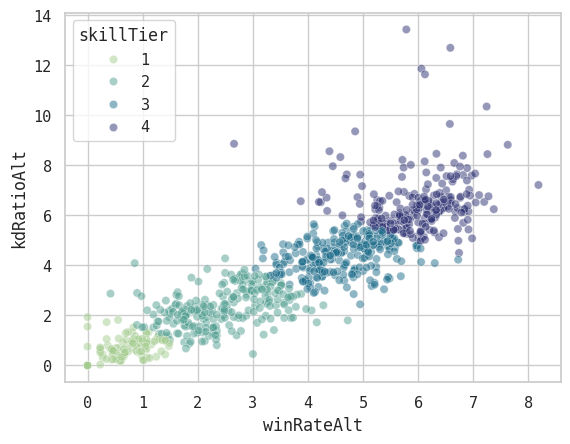

In [8]:
sns.scatterplot(data=df,
                x='winRateAlt',
                y='kdRatioAlt',
                color='#9090cc',
                alpha=0.5,
                hue = 'skillTier',
                palette='crest',
                marker='o')

## Classification

---

Based on the four classes derived above, we'll proceed to conduct multi-class classification.

> Because of the class imbalance, i.e, there are significantly more people in the lowest skill bracket compared to other brackets,
> we have to ensure that during `train_test_split`, we use the `stratify` option to preserve the class proportions in both the
> train and test sets. Additionally, in computing an overall metric to characterise the performance of a classifier, we have adopted
> the **F1 score**. This is computed as the harmonic mean of the precision and recall. The F1 scores are *macro-averaged* because
> while most models are great at classifying players who belong to the lowest skill tier, we want to acknowledge the deficiencies
> in classifying other skill tiers. If we were to use a weighted average, the resulting F1 score would be high regardless of the low
> F1 scores in the minority classes. Therefore we opted for the macro average instead.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [10]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'skillTier'

In [11]:
def model_evaluation_w_grid_search(df, predictors, target, model_instance, param_grid, cv):
    df_train, df_test = train_test_split(df, test_size=0.2, stratify=df[[target]])
    
    model = GridSearchCV(estimator=model_instance, param_grid=param_grid, cv=cv, scoring='f1_macro')
    model.fit(df_train[predictors], df_train[[target]])

    print('<<- Grid Search Results (Best Parameters) ->>\n')
    for k, v in model.best_params_.items():
       print(f'{k:10}\t{v}')
    print()

    pred_train, pred_test = model.predict(df_train[predictors]), model.predict(df_test[predictors])

    print('<<- Classification Report (Train Set) ->>\n')
    print(classification_report(df_train[[target]], pred_train, target_names=['1', '2', '3', '4']))
    print('<<- Classification Report (Test Set) ->>\n')
    print(classification_report(df_test[[target]], pred_test, target_names=['1', '2', '3', '4']))
    
    return f1_score(df_test[[target]], pred_test, average='macro')

In [12]:
model_performance = {}

In [13]:
param_grid = {
    'penalty': ['l1', 'l2', 'elastinet'],
    'C':       [0.1, 1, 10, 100],
    'solver':  ['lbfgs', 'lib_linear']
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=LogisticRegression(),
    param_grid=param_grid,
    cv=3
)

model_performance['LogisticRegression'] = f1

<<- Grid Search Results (Best Parameters) ->>

C         	0.1
penalty   	l2
solver    	lbfgs

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       0.94      0.96      0.95       659
           2       0.60      0.25      0.35       190
           3       0.57      0.49      0.53       210
           4       0.50      0.85      0.63       187

    accuracy                           0.75      1246
   macro avg       0.65      0.64      0.61      1246
weighted avg       0.76      0.75      0.74      1246

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.93      0.97      0.95       165
           2       0.69      0.23      0.35        47
           3       0.56      0.34      0.42        53
           4       0.41      0.81      0.55        47

    accuracy                           0.73       312
   macro avg       0.65      0.59      0.57       312
weight

In [14]:
param_grid = {
    'tol':      [1e-4, 1e-3, 1e-2, 1e-1],
    'C':        [0.1, 1, 10, 100],
    'max_iter': [-1, 1_000, 10_000]
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=SVC(),
    param_grid=param_grid,
    cv=3
)

model_performance['SVC'] = f1

<<- Grid Search Results (Best Parameters) ->>

C         	100
max_iter  	1000
tol       	0.0001

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       0.83      0.93      0.88       659
           2       0.40      0.13      0.20       190
           3       0.59      0.63      0.61       210
           4       0.67      0.80      0.73       187

    accuracy                           0.74      1246
   macro avg       0.62      0.62      0.60      1246
weighted avg       0.70      0.74      0.71      1246

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.82      0.88      0.85       165
           2       0.35      0.15      0.21        47
           3       0.59      0.64      0.61        53
           4       0.70      0.85      0.77        47

    accuracy                           0.73       312
   macro avg       0.62      0.63      0.61       312
wei

In [15]:
param_grid = {
    'n_neighbors': [5, 10, 15, 20, 25],
    'algorithm':   ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size':   [5, 10, 15, 20, 25]
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=3
)

model_performance['KNeighborsClassifier'] = f1

<<- Grid Search Results (Best Parameters) ->>

algorithm 	ball_tree
leaf_size 	5
n_neighbors	25

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       0.94      0.85      0.90       659
           2       0.61      0.57      0.59       190
           3       0.58      0.71      0.64       210
           4       0.69      0.80      0.74       187

    accuracy                           0.78      1246
   macro avg       0.71      0.73      0.72      1246
weighted avg       0.79      0.78      0.78      1246

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.97      0.80      0.88       165
           2       0.52      0.55      0.54        47
           3       0.49      0.64      0.55        53
           4       0.62      0.74      0.68        47

    accuracy                           0.73       312
   macro avg       0.65      0.68      0.66       312
wei

In [16]:
param_grid = {
    'criterion':    ['gini', 'entropy', 'log_loss'],
    'max_depth':    [None, 5, 10, 15],
    'max_features': [None, 'sqrt', 'log2']
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=3
)

model_performance['DecisionTreeClassifier'] = f1

<<- Grid Search Results (Best Parameters) ->>

criterion 	gini
max_depth 	5
max_features	None

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       1.00      0.99      0.99       659
           2       0.91      0.98      0.94       190
           3       0.90      0.83      0.86       210
           4       0.87      0.91      0.89       187

    accuracy                           0.95      1246
   macro avg       0.92      0.93      0.92      1246
weighted avg       0.95      0.95      0.95      1246

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       165
           2       0.84      0.91      0.88        47
           3       0.80      0.75      0.78        53
           4       0.83      0.81      0.82        47

    accuracy                           0.91       312
   macro avg       0.86      0.87      0.86       312
weigh

In [17]:
param_grid = {
    'criterion':     ['gini', 'entropy', 'log_loss'],
    'max_depth':     [None, 5, 10, 15],
    'n_estimators':  [50, 100, 150]
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=RandomForestClassifier(),
    param_grid=param_grid,
    cv=3
)

model_performance['RandomForestClassifier'] = f1

<<- Grid Search Results (Best Parameters) ->>

criterion 	gini
max_depth 	None
n_estimators	150

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       659
           2       1.00      1.00      1.00       190
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       187

    accuracy                           1.00      1246
   macro avg       1.00      1.00      1.00      1246
weighted avg       1.00      1.00      1.00      1246

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       165
           2       0.96      0.91      0.93        47
           3       0.86      0.96      0.91        53
           4       0.98      0.87      0.92        47

    accuracy                           0.96       312
   macro avg       0.95      0.94      0.94       312
wei

In [18]:
param_grid = {
    'learning_rate': [0.1, 0.5],
    'n_estimators':  [50, 100, 150]
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=GradientBoostingClassifier(),
    param_grid=param_grid,
    cv=3
)

model_performance['GradientBoostingClassifier'] = f1

<<- Grid Search Results (Best Parameters) ->>

learning_rate	0.5
n_estimators	50

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       659
           2       1.00      1.00      1.00       190
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       187

    accuracy                           1.00      1246
   macro avg       1.00      1.00      1.00      1246
weighted avg       1.00      1.00      1.00      1246

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       165
           2       0.90      0.94      0.92        47
           3       0.78      0.79      0.79        53
           4       0.84      0.77      0.80        47

    accuracy                           0.92       312
   macro avg       0.88      0.87      0.87       312
weighted avg      

(0.0, 1.2212790735950734)

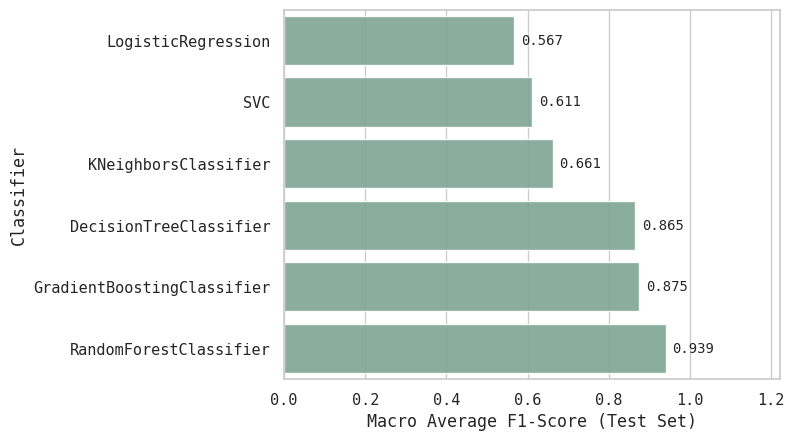

In [19]:
pairs = sorted((v, k) for k, v in model_performance.items())
result = {
    'Classifier': [pair[1] for pair in pairs],
    'Macro Average F1-Score (Test Set)': [pair[0] for pair in pairs]
}
ax = sns.barplot(data=pd.DataFrame(result),
                 x='Macro Average F1-Score (Test Set)',
                 y='Classifier',
                 orient='y',
                 color='#78aa98',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.3f')
ax.set_xlim(0, result['Macro Average F1-Score (Test Set)'][-1] * 1.3)